
=== Training Scaled Model ===
Epoch   1/200 | Train Loss: 1.6965 Acc: 0.2519 | Val Loss: 1.6449 Acc: 0.2778
Epoch   2/200 | Train Loss: 1.7085 Acc: 0.2560 | Val Loss: 1.6310 Acc: 0.2778
Epoch   3/200 | Train Loss: 1.6462 Acc: 0.2641 | Val Loss: 1.6178 Acc: 0.3056
Epoch   4/200 | Train Loss: 1.6884 Acc: 0.2560 | Val Loss: 1.6044 Acc: 0.3056
Epoch   5/200 | Train Loss: 1.6554 Acc: 0.2478 | Val Loss: 1.5910 Acc: 0.3056
Epoch   6/200 | Train Loss: 1.6125 Acc: 0.2560 | Val Loss: 1.5784 Acc: 0.3056
Epoch   7/200 | Train Loss: 1.5988 Acc: 0.2597 | Val Loss: 1.5657 Acc: 0.3056
Epoch   8/200 | Train Loss: 1.6009 Acc: 0.2556 | Val Loss: 1.5530 Acc: 0.3056
Epoch   9/200 | Train Loss: 1.5653 Acc: 0.2679 | Val Loss: 1.5405 Acc: 0.3056
Epoch  10/200 | Train Loss: 1.5991 Acc: 0.2638 | Val Loss: 1.5279 Acc: 0.3333
Epoch  11/200 | Train Loss: 1.5520 Acc: 0.2879 | Val Loss: 1.5156 Acc: 0.3333
Epoch  12/200 | Train Loss: 1.5703 Acc: 0.2839 | Val Loss: 1.5034 Acc: 0.3333
Epoch  13/200 | Train Loss: 1.550

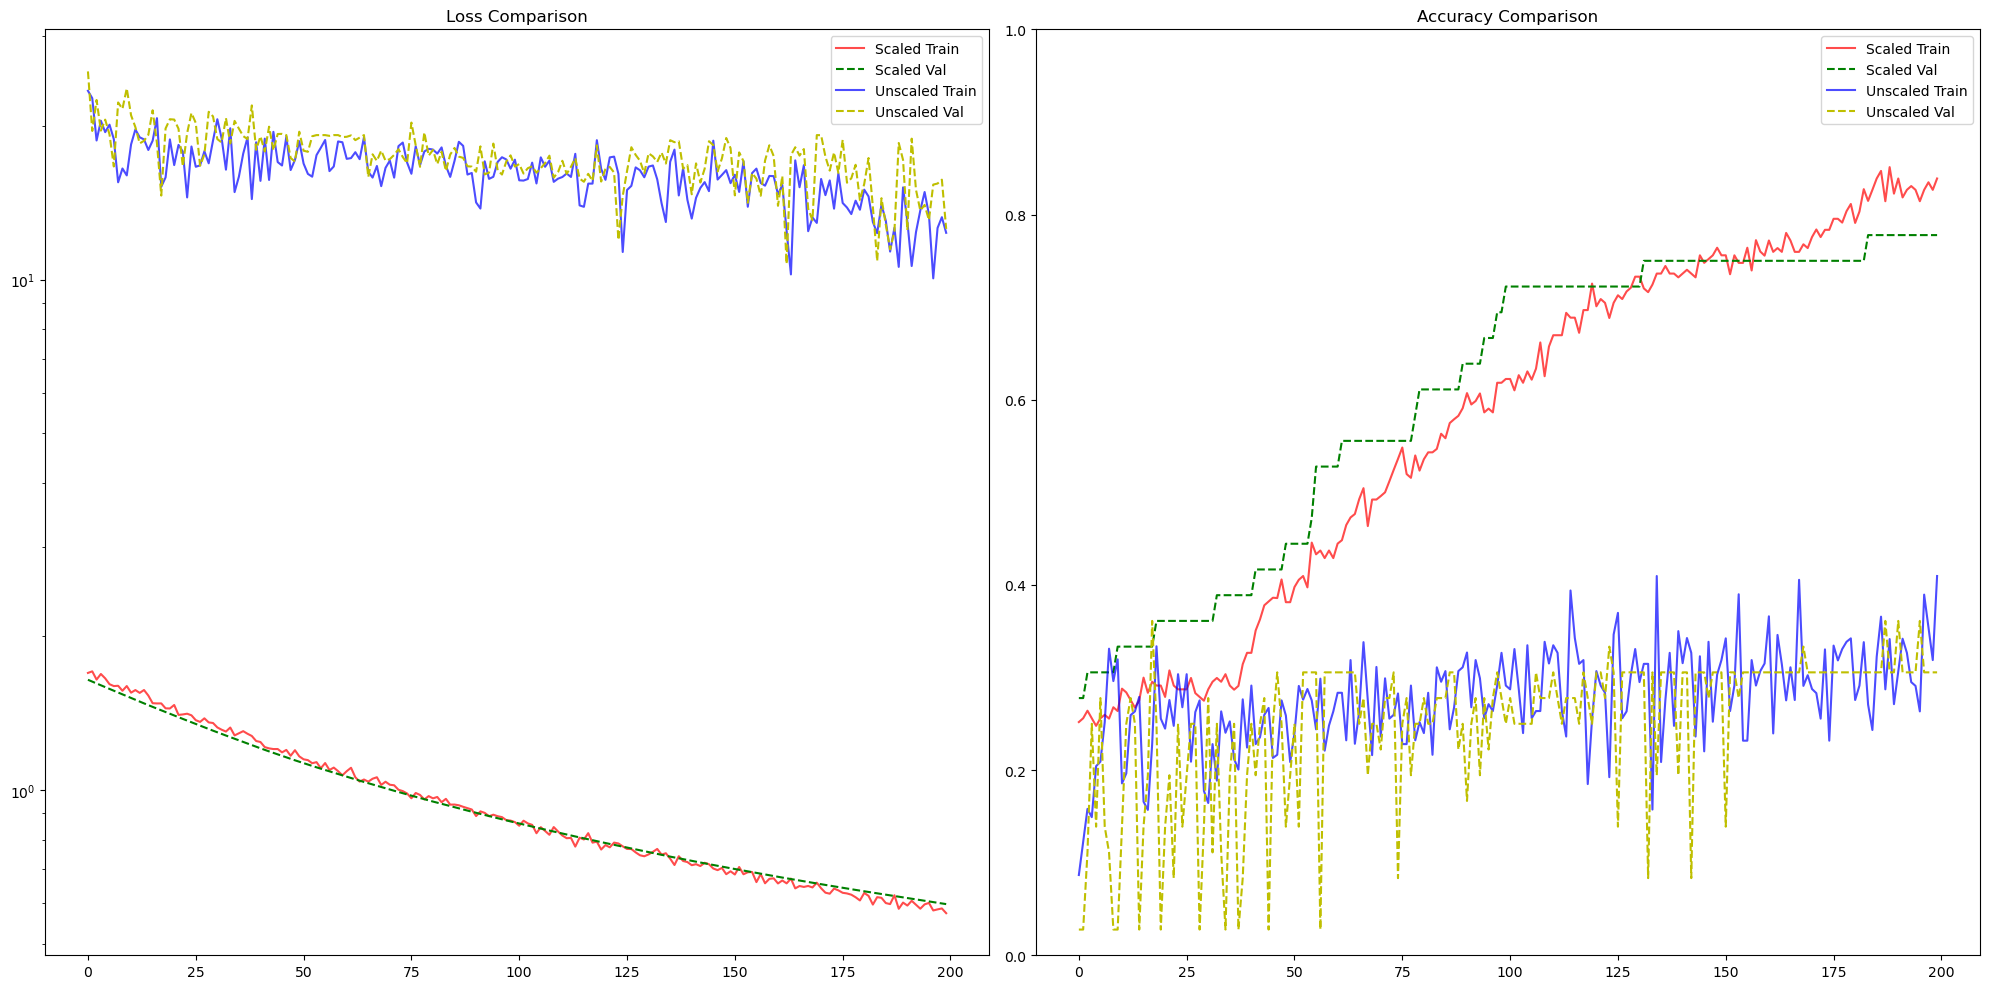

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# ------------------- activate functions and loss function -------------------
def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true_labels):
    batch_size = y_pred.shape[0]
    num_classes = y_pred.shape[1]
    y_true_onehot = np.zeros((batch_size, num_classes))
    y_true_onehot[np.arange(batch_size), y_true_labels.flatten().astype(int)] = 1
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.sum(y_true_onehot * np.log(y_pred)) / batch_size

# ------------------- neural network -------------------
class NeuralNet_wine:
    def __init__(self, input_dim, output_dim, neurons=[64, 32]):
        self.weights = []
        self.biases = []
        self.activation_funcs = []
        
        # initialization
        prev_dim = input_dim
        for n in neurons:
            self.weights.append(np.random.randn(prev_dim, n) * np.sqrt(2./prev_dim))
            self.biases.append(np.zeros((1, n)))
            self.activation_funcs.append("leaky_relu")
            prev_dim = n
        
        # output layer
        self.weights.append(np.random.randn(prev_dim, output_dim) * np.sqrt(2./prev_dim))
        self.biases.append(np.zeros((1, output_dim)))
        self.activation_funcs.append("softmax")
        
    def forward_wine(self, x):
        self.cache = []
        a_prev = x
        for w, b, af in zip(self.weights, self.biases, self.activation_funcs):
            z = np.dot(a_prev, w) + b
            if af == "leaky_relu":
                a = leaky_relu(z)
            elif af == "softmax":
                
                a = softmax(z)
            # save: input activate value, linear output, activate output  
            self.cache.append( (a_prev.copy(), z.copy(), a.copy()) )
            a_prev = a
        return a_prev
    
    def backward_wine(self, y_true_onehot, learning_rate):
        m = y_true_onehot.shape[0]
        gradients = []
        
        # output layer gradients
        a_prev, z, a = self.cache[-1]
        delta = (a - y_true_onehot) / m
        gradients.append(delta)
        
        # hidden layer backpropagation
        for i in reversed(range(len(self.weights)-1)):
            w_next = self.weights[i+1]
            a_prev, z, a = self.cache[i]
            delta = np.dot(delta, w_next.T) * (z > 0).astype(float)
            gradients.append(delta)
        
        # reversing the gradient list
        gradients = gradients[::-1]
        
        # updating parameters
        for i in range(len(self.weights)):
            a_prev, z, a = self.cache[i]
            dW = np.dot(a_prev.T, gradients[i])
            db = np.sum(gradients[i], axis=0, keepdims=True)
            
            # shape validation
            assert dW.shape == self.weights[i].shape, \
                f"Gradient shape{dW.shape} vs Weight shape{self.weights[i].shape}"
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
    
    def train_wine(self, X_train, y_train, X_val, y_val, 
             epochs=200, batch_size=64, learning_rate=1e-3, patience=10):
        y_train_onehot = np.zeros((len(y_train), self.weights[-1].shape[1]))
        y_train_onehot[np.arange(len(y_train)), y_train] = 1
        
        history = {'train_loss': [], 'train_acc': [], 
                  'val_loss': [], 'val_acc': []}
        best_val_loss = float('inf')
        no_improve = 0
        
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            epoch_loss = []
            epoch_acc = []
            
            for i in range(0, len(X_train), batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch = X_train[batch_idx]
                y_batch_labels = y_train[batch_idx]
                y_batch_onehot = y_train_onehot[batch_idx]
                
                # forward propagation
                output = self.forward_wine(X_batch)
                loss = cross_entropy_loss(output, y_batch_labels)
                acc = np.mean(np.argmax(output, axis=1) == y_batch_labels)
                
                # back-propagation
                self.backward_wine(y_batch_onehot, learning_rate)
                
                epoch_loss.append(loss)
                epoch_acc.append(acc)
            
            # validation
            val_output = self.forward_wine(X_val)
            val_loss = cross_entropy_loss(val_output, y_val)
            val_acc = np.mean(np.argmax(val_output, axis=1) == y_val)
            
            # 
            history['train_loss'].append(np.mean(epoch_loss))
            history['train_acc'].append(np.mean(epoch_acc))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
        
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                 f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f} | "
                 f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        return history

# ------------------- data preprocessing -------------------
def data_wine():
    wine = pd.read_csv('wine.csv').drop(0)
    X = wine.drop("class", axis=1).values.astype(float)
    y = wine["class"].values.astype(int)
    y = np.vectorize({1:0, 2:1, 3:2}.get)(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# ------------------- mian -------------------
def main_wine():
    X_train, X_val, X_test, y_train, y_val, y_test = data_wine()
    
    # data scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # training scaled model
    print("\n=== Training Scaled Model ===")
    nn_scaled = NeuralNet_wine(input_dim=X_train_scaled.shape[1], output_dim=3)
    history_scaled = nn_scaled.train_wine(
        X_train_scaled, y_train, X_val_scaled, y_val,
        learning_rate=5e-4, epochs=200, patience=10
    )
    
    # training unscaled model
    print("\n=== Training Unscaled Model ===")
    nn_raw = NeuralNet_wine(input_dim=X_train.shape[1], output_dim=3)
    history_raw = nn_raw.train_wine(
        X_train, y_train, X_val, y_val,
        learning_rate=1e-5, epochs=200, patience=10
    )
    
    # visulization
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.plot(history_scaled['train_loss'], label='Scaled Train', c='r', alpha=0.7)
    plt.plot(history_scaled['val_loss'], '--', c='g', label='Scaled Val')
    plt.plot(history_raw['train_loss'], label='Unscaled Train', c='b', alpha=0.7)
    plt.plot(history_raw['val_loss'], '--', c='y', label='Unscaled Val')
    plt.yscale('log')
    plt.title("Loss Comparison")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history_scaled['train_acc'], label='Scaled Train', c='r', alpha=0.7)
    plt.plot(history_scaled['val_acc'], '--', c='g', label='Scaled Val')
    plt.plot(history_raw['train_acc'], label='Unscaled Train', c='b', alpha=0.7)
    plt.plot(history_raw['val_acc'], '--', c='y', label='Unscaled Val')
    plt.ylim(0.0, 1.0)
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

main_wine()